2. Image stitching python version 3.7, opencv version 3.4.2

2.1 coding questions

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
def warpPerspectivePadded(
        src, dst_shape, M):
    """Performs an affine or Euclidean/rigid warp with padding.
    Parameters
    ----------
    src : image to be warped.
    dst : shape of static image i.e. dst.shape 
    M : `3x3` Homography matrix.
    Returns
    -------
    src_warped : padded and warped source image
    """
    
    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    _, src_w = src.shape[:2]
    lin_pts = np.array([
        [0, src_w],
        [0, 0]])
    # transform points
    transf_lin_pts = M[:, :2].dot(lin_pts) + M[:, 2].reshape(3, 1)

    # find min and max points
    min_x = np.floor(np.min(transf_lin_pts)).astype(int)
    max_x = np.ceil(np.max(transf_lin_pts)).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x = 0
    if min_x < 0:
        anchor_x = -min_x
    shifted_transf = M + [[0, 0, anchor_x], [0, 0, 0], [0, 0, 0]]

    # create padded destination image
    dst_h, dst_w,_ = dst_shape
    dst_pad_w = anchor_x + dst_w + max(max_x, dst_w) - dst_w
    src_warped = cv2.warpPerspective(src, shifted_transf, (dst_pad_w, dst_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return src_warped

def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a



1. Compute SIFT keypoint and corresponding descriptors for images 1Hill and 2Hill

In [2]:
start_time = time.time()
# Read images
img1 = cv2.imread('1Hill.jpg')
img2 = cv2.imread('2Hill.jpg')

# Convert images into RGB mode
img1RGB = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2RGB = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Get copy of each img in order to display the SIFT keypoints.
img1Draw = img1RGB.copy()
img2Draw = img1RGB.copy()

# Calculate the keypoints and descriptors using built-in function
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift_obj.detectAndCompute(img1RGB, None)
keypoints_2, descriptors_2 = sift_obj.detectAndCompute(img2RGB, None)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.14270997047424316 seconds ---


2. Find matching keypoints in two images and display the 20 best pairs

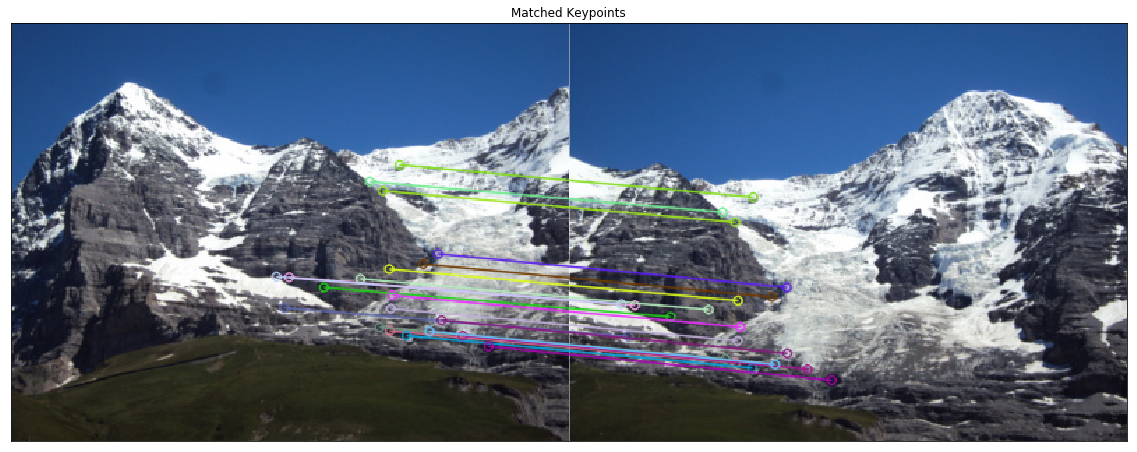

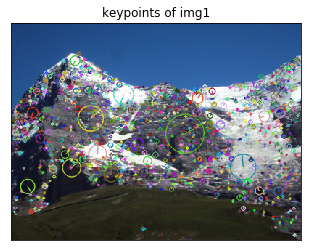

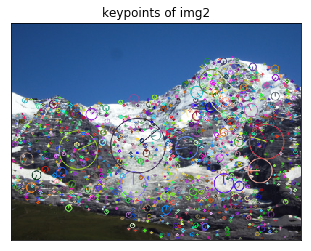

In [3]:
# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.match(descriptors_1,descriptors_2)

# Sort keypoints
matches = sorted(matches, key = lambda x:x.distance)

# Use built-in function to draw 20 best matches
imgmatch = cv2.drawMatches(img1RGB,keypoints_1,img2RGB,keypoints_2, matches[:20], img1RGB, flags=2)

# Display SIFT keypoints
drawKeypts1 = cv2.drawKeypoints(img1RGB, keypoints_1, img1Draw, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
drawKeypts2 = cv2.drawKeypoints(img2RGB, keypoints_2, img2Draw, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,20))
plt.imshow(imgmatch)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(drawKeypts1)
plt.title("keypoints of img1"), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(drawKeypts2)
plt.title("keypoints of img2"), plt.xticks([]), plt.yticks([])
plt.show()

3. Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

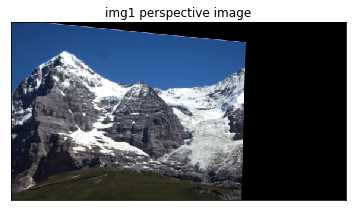

In [4]:
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mp2 = np.float32([keypoints_2[i].pt for (i,__ ) in GoodMatches])
mp1 = np.float32([keypoints_1[i].pt for (__, i) in GoodMatches])

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mp1, mp2, cv2.RANSAC, 4)
wimg = warpPerspectivePadded(img1RGB,img1RGB.shape,H)

# get a copy of wimg to perform further actions
wimg1=wimg.copy()

#wimg[:,(wimg.shape[1]-img2RGB.shape[1]):,:]=img2RGB (direct stitching)

#display the warpperspectivepadded version of img1RGB
plt.imshow(wimg)
plt.title("img1 perspective image"), plt.xticks([]), plt.yticks([])
plt.show()
# increase the size of img2RGB to perform stitching
# 164=564(length of wimg1)-400(length of img2RGB)
difference=wimg.shape[1]- img2RGB.shape[1]
img2RGB=cv2.copyMakeBorder(img2RGB,0,0,difference,0,cv2.BORDER_CONSTANT,(0,0,0,0))


4. Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

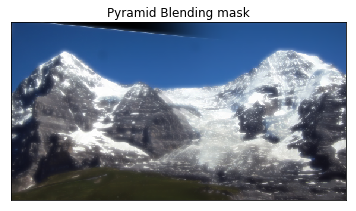

--- 0.15024304389953613 seconds ---


In [5]:
start_time = time.time()
g_size = 255  # gaussian mask blur size
depth = 3  # pyramid depth size

""" PYRAMID BLENDING """
row, col, dpt = wimg1.shape
# generate Gaussian pyramid for imgA
G = wimg1.copy()
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# generate Gaussian pyramid for imgB
G = img2RGB.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:,:round(164)], lb[:,round(164):]))
    LP.append(lp)

# build Gaussian pyramid from selected region
mask = np.zeros((wimg1.shape[0], wimg1.shape[1]))

# create mask
mask[:, round(wimg1.shape[1]/2):] = 1

# blur mask
mask = cv2.GaussianBlur(mask, (g_size, g_size), 0)

# generate Gaussian pyramid
G = mask.copy()
GR = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    GR.append(G)

#add left and right halves of images in each level using Gaussian mask
LP_mask = []
i = 1
for la, lb in zip(lp1, lp2):
    idx = depth - i
    # Now blend
    lp = (1-GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1)) * la + \
         GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1) * lb
    lp = np.uint8(lp)  # convert back to uint8
    LP_mask.append(lp)
    i += 1

# now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs)  # upsample current lp image
    rs = cv2.add(rs, LP[i])  # add lp image

# now Gaussian mask reconstruct
rs_mask = LP_mask[0]
for i in range(1, depth):
    rs_mask = cv2.pyrUp(rs_mask)  # upsample current lp image
    rs_mask = cv2.add(rs_mask, LP_mask[i])  # add lp image

# get a copy of the masked image to perform further operation
otwoHill = rs_mask.copy()

#display image
plt.title('Pyramid Blending mask'), plt.xticks([]), plt.yticks([])
plt.imshow(rs_mask)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

1. Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.

In [6]:
start_time = time.time()
# read image
img3 = cv2.imread('3Hill.jpg')

# convert image into RGB mode
img3RGB = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# get a copy of img3 and otwoHill to draw keypoints
img3Draw = img3RGB.copy()
otwoHillDraw = otwoHill.copy()

# compute keypoints and descriptors
surf_obj = cv2.xfeatures2d.SURF_create()
keypoints_3, descriptors_3 = surf_obj.detectAndCompute(img3RGB, None)
keypoints_4, descriptors_4 = surf_obj.detectAndCompute(otwoHill, None)
print("--- %s seconds ---" % (time.time() - start_time))


--- 0.1606597900390625 seconds ---


2. Find matching keypoints in two images and display the 20 best pairs.

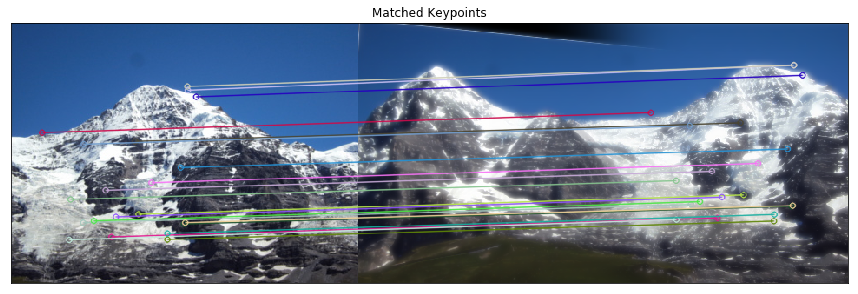

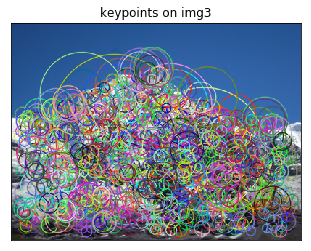

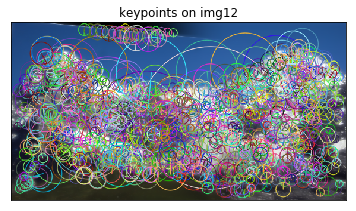

In [7]:
# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_3,descriptors_4)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw 20 best matched keypoints 
imgmatch = cv2.drawMatches(img3RGB,keypoints_3,otwoHill,keypoints_4, matches[:20], img3RGB, flags=2)

# Draw keypoint on each picture
drawKeypts3 = cv2.drawKeypoints(img3RGB, keypoints_3, img3Draw, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
drawKeypts12 = cv2.drawKeypoints(otwoHill, keypoints_4, otwoHillDraw, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display images
plt.figure(figsize=(15,15))
plt.imshow(imgmatch)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(drawKeypts3)
plt.title("keypoints on img3"), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(drawKeypts12)
plt.title("keypoints on img12"), plt.xticks([]), plt.yticks([])
plt.show()

3. Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed.

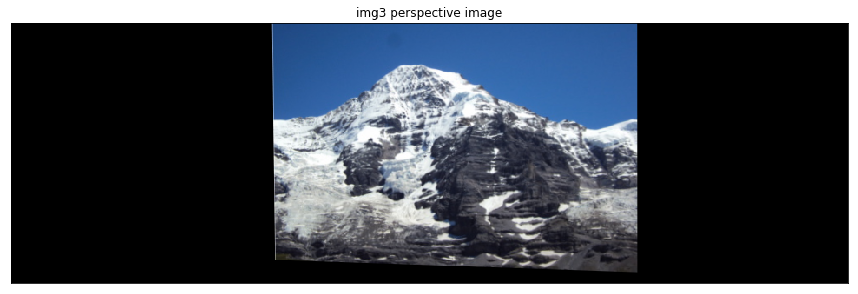

In [8]:
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mp3 = np.float32([keypoints_3[i].pt for (__, i) in GoodMatches])
mp4 = np.float32([keypoints_4[i].pt for (i, __) in GoodMatches])

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mp3, mp4, cv2.RANSAC, 4)

# get the warpperspectivepadded version img3RGB
img3RGB2 = warpPerspectivePadded(img3RGB,img3RGB.shape,H)

otwoHillb=cv2.copyMakeBorder(otwoHill,0,0,0,400,cv2.BORDER_CONSTANT,(0,0,0,0))

# get the warpperspective version of img3RGB
img3transformed1=cv2.warpPerspective(img3RGB, H, (img3RGB.shape[1]+otwoHill.shape[1],img3RGB.shape[0]))

#display the image
plt.figure(figsize=(15,15))
plt.imshow(img3transformed1)
plt.title("img3 perspective image"), plt.xticks([]), plt.yticks([])
plt.show()

4. Stitch transformed 3Hill and 12Hill together and apply linear image blending.

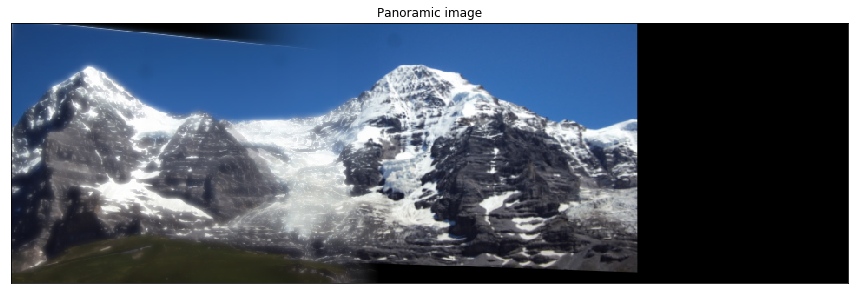

--- 0.26958799362182617 seconds ---


In [9]:
start_time = time.time()
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(otwoHillb.shape[1], ramp_size, round(img3transformed1.shape[1]-otwoHill.shape[1]), 0, 1)

# blend
I_blend = (1-alpha.reshape(1,-1,1)) * otwoHillb + alpha.reshape(1,-1,1)*img3transformed1
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(15,15))
plt.imshow(I_blend)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

2.2 reasoning question

1.What are the difference between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics

Answers: 
    SIFT and SURF are similiar in implementation. Each run they used different time but in general SURF has less time than SIFT. Also, by observation, we should be able to see that SURF has more and denser keypoints than SIFT.

2.Discuss at least two pros and cons of pyramid and linear blending. When should one prefer pyramid over linear blending?

Answers:
pyramid blending:

pros : 
1.Make the connections look more natural
2.Take in more information when blending, since image pyramids represents the spatial look of an image in different frequency.

cons : 
1.If the connection part has black borader, which is not part of the original picture, the stitching will have a clear trace of human artifact.
2.Take more time to compute
    
Linear blending:

pros :
1. easy to be implemented and quicker compared with pyramid blending
2. do not have the issue that take in black border as part of the image

cons : 
1. sometimes make the picture seems unnatural if two pictures have different light conditions.
2. doesnot take depth of the image into consideration

When the light condition of two images has a great difference, we should prefer pyramid over linear.

3.What would happen if a random subset of pairs of matching keypoints is used for finding homography?

Depending on how good the random selected one is. The result is more likely to be bad, since we have 20 best keypoints after sorting. But the random may not be the 20 best matches. 

4.Discuss the relationship between the number of pairs of matching keypoints used for finding homography and the accuracy of inferred homography?

Answer:
    This really depends on the quality of the pairs. If we have numbers of pairs of matching keypoints, which are equivalently good as many as possible, the more we use them to find the homography, the more accurate the inferred homography would be. However, if the pairs are not good mathing points, we'd better not using them since it will produce more offset into the inferred homography